# Model training on FBM
> Example of training SPIVAE to extract the relevant physical parameters of fractional Brownian motion.

In this tutorial,
we aim at training SPIVAE with the dataset of fractional Brownian motion (FBM) to extract the generalized diffusion coefficient $D$, and the anomalous exponent $\alpha$.

In [ ]:
#|hide
from SPIVAE.imports import *

# Parameters

To train the models, we use the [fastai](https://docs.fast.ai/) library that provides easy to use methods.
First, we gather everything needed to train (the data, the model, the loss, the optimizer, etc.)
into a `Learner` object.
We will use the `Learner` to hold all the parameters and handle the training procedure.

We start selecting the parameters of the device to train on, the dataset, and the model. 

In [ ]:
DEVICE= 'cpu'  # 'cuda'
print(DEVICE)

cpu


To construct the dataset of FBM, we vary $D$ logarithmically inside the range $10^{-5}$ and $10^{-2}$ such that the displacements are smaller than one.
At the same time, we choose $\alpha\in[0.2, 1.8]$. 
We take the same amount of trajectories for each combination of parameters, about 100 thousand trajectories in total. 
We split them in training and validation sets, and select a batch size `bs`.

In [ ]:
Ds = np.geomspace(1e-5,1e-2, 10) 
alphas = np.linspace(0.2,1.8,21)
n_alphas, n_Ds = len(alphas), len(Ds)
ds_args = dict(path="../../data/raw/", model='fbm', # 'sbm'
               N=int(100_000/n_alphas/n_Ds), T=400,
               D=Ds, alpha=alphas,
               N_save=6_000, T_save=400,
               seed=0, valid_pct=0.2, bs=2**8,)

We generate training data as explained in the [data docs](../source/data.html#fractional-brownian-motion). You can skip this step if you already generated data using the data generation notebook.

In [ ]:
dataset = AD.create_dataset(T=ds_args["T"], N_models=ds_args["N"],
                            exponents=ds_args["alpha"],
                            dimension=1, models=[2],  # fbm
                            t_save=ds_args["T_save"], N_save=ds_args["N_save"],
                            save_trajectories=True, path="../../data/raw/")

We create the data loaders `dls` for training and validation with the parameters we selected above. 

In [ ]:
dls = load_data(ds_args).to(DEVICE)
dls[1].drop_last = True # for validation to throw the last incomplete batch or not
dls[0].drop_last, dls[1].drop_last, dls[1].bs, dls.device

(True, True, 256, 'cpu')

We set a small model to train rapidly, but large enough to provide adequate expressiveness. 
We fix 6 latent neurons, as a priori, we do not know how many neurons will encode the trajectory parameters.

In [ ]:
model_args = dict(# VAE #################
                  o_dim=ds_args['T']-1,
                  nc_in=1,  # 1D
                  nc_out=6, # = z_dim
                  nf=[16]*4,
                  avg_size=16,
                  encoder=[200,100],
                  z_dim=6,  # latent dimension
                  decoder=[100,200],
                  beta=0,
                  # WaveNet ############
                  in_channels=1,
                  res_channels=16,skip_channels=16,
                  c_channels=6, # = nc_out
                  g_channels=0,
                  res_kernel_size=3,
                  layer_size=4,  # 6  # Largest dilation is 2**layer_size
                  stack_size=1,
                  out_distribution= "Normal",
                  num_mixtures=1,
                  use_pad=False,    
                  model_name = 'SPIVAE',
                 )

We initialize a model and define its loss function as defined in [Utils](../source/utils.html).
The initial loss for this dataset is around 1.5, bigger than that the initialization provides an unstable model that may not train properly.

In [ ]:
model = VAEWaveNet(**model_args).to(DEVICE)
print('RF:', model.receptive_field, 'bs:', dls.bs)
x,y=b = dls.one_batch(); t = model(x)
loss_fn = Loss(model.receptive_field, model.c_channels, 
                    beta=model_args['beta'], reduction='mean')
l = loss_fn(t,y).item(); 
print('Initial loss: ',l)
assert l<1.5, 'Initial loss should be around 1.5 or less'

RF: 32 bs: 256
Initial loss:  0.9262354373931885


We now set a few callback functions to show relevant information during training.
The first two update a plot of the total loss for training and validation, and the Kullback-Leibler divergence ($D_{KL}$) of the latent neurons, respectively.
The other two record the reconstruction loss and the $D_{KL}$ of each latent neuron.

In [ ]:
callbacks = [ShowLossCallback(), ShowKLDsCallback(),
             GMsCallback(model.receptive_field,model.c_channels),
             KLDsCallback(model.c_channels)]

We add two metrics to follow the reconstruction loss and the divergence term during training.

In [ ]:
metrics = [GaussianMixtureMetric(model.receptive_field, model.c_channels,reduction='mean'),
           KLDMetric(model.c_channels,),
          ]

With all the ingredients, we create the `Learner` with the default optimizer, Adam.

In [ ]:
learn = Learner(dls, model, loss_func=loss_fn, opt_func=Adam, cbs=callbacks, metrics=metrics,)
if torch.cuda.is_available() and DEVICE=='cuda': learn.model.cuda()

The learner can show us a summary including the model sizes and number of parameters.

In [ ]:
learn.summary()

VAEWaveNet (Input shape: 256 x 1 x 399)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 16 x 397      
Conv1d                                    64         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 16 x 395      
Conv1d                                    784        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 16 x 393      
Conv1d                                    784        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 16 x 391      
Conv1d                                    784        True      
ReLU                                             

Finally, we need a learning rate. 
Conveniently, [fastai](https://docs.fast.ai/) includes a [learning rate finder](https://docs.fast.ai/callback.schedule.html#learner.lr_find).
This finder can suggest some points, each based on a criterion that guides us.
Hence, we try with one order above and below the default criterion, the [valley](https://docs.fast.ai/callback.schedule.html#valley).

SuggestedLRs(valley=9.120108734350652e-05)

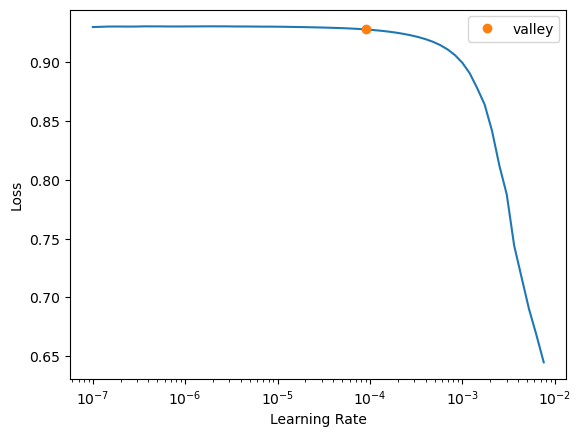

In [ ]:
learn.lr_find()

The valley is around $10^{-4}$, thus we will start trying a learning rate of $10^{-3}$ to see if we can learn fast.

During the search, not only the loss was logged but also the $D_{KL}$ which we can see here:

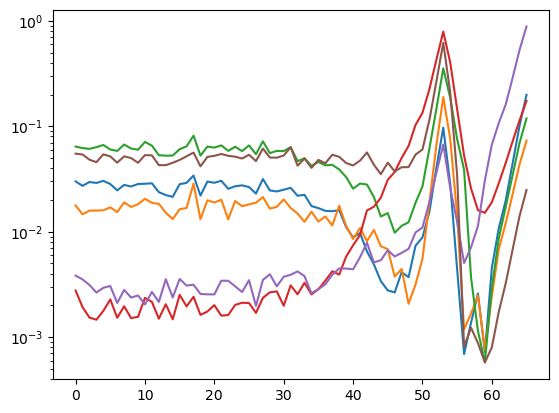

In [ ]:
plt.semilogy(np.stack(learn.kl_ds.preds)); learn.kl_ds.preds=[]

During the training, we will keep an eye on both the total loss and the $D_{KL}$.

# Training with $\beta$=0

We start training with $\beta=0$ to have no additional constraint in the latent neurons and allow the VAE to use the full capacity of its bottleneck.

In [ ]:
learn.loss_func.beta=0

To ease the training, we update the model's parameters following the learning rate schedule developed by [Leslie N. Smith et al. (2017)](https://arxiv.org/abs/1708.07120) and already implemented in [fastai](https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle). We choose as the maximum learning rate the one derived from the finder above. 

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-1.315952,-1.661407,-1.661407,19.406342,01:09
1,-2.112537,-2.151353,-2.151353,64.277298,01:10
2,-2.239122,-2.249071,-2.249071,86.196838,01:11
3,-2.244182,-2.256283,-2.256283,78.044266,01:10
4,-2.238847,-2.265728,-2.265728,79.355087,01:10
5,-2.185477,-2.220979,-2.220979,73.193192,01:11
6,-2.157342,-2.245884,-2.245884,68.523232,01:11
7,-2.011828,-2.076498,-2.076498,48.271271,01:10
8,-2.026002,-2.205460,-2.205460,14.866062,01:10
9,-2.146519,-2.218804,-2.218804,27.197741,01:12


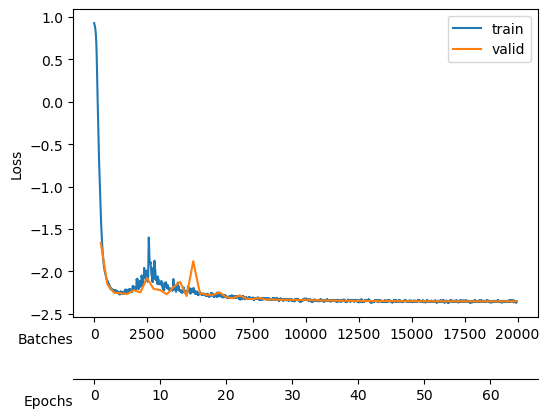

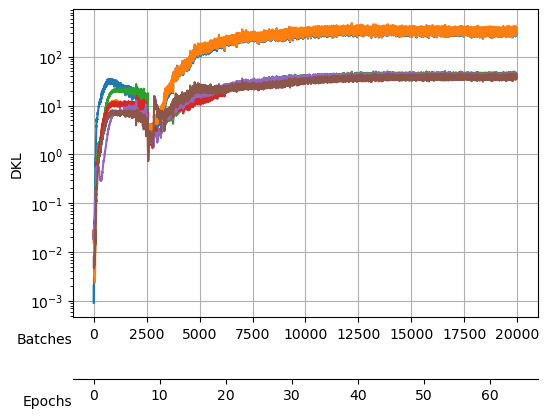

In [ ]:
learn.fit_one_cycle(64, lr_max=1e-3,)

After training, we see a validation loss around -2.35 and two neurons that contribute the most to the $D_{KL}$.
We take a checkpoint of the model at this moment.

In [ ]:
E=64; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E64.tar


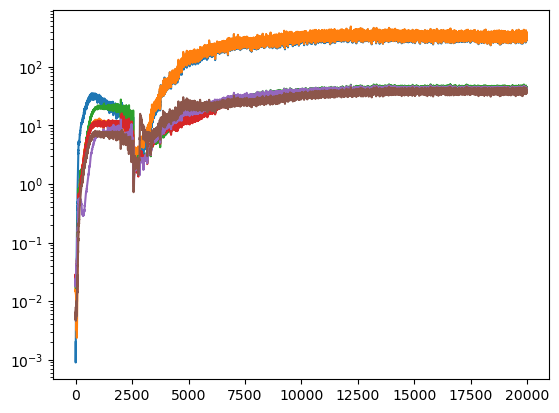

In [ ]:
plt.semilogy(np.stack(learn.kl_ds.preds));

# Annealing $\beta$

Now, we increase $\beta$ to impose a Gaussian prior into the latent neurons distribution which effectively forces the encoding of the already present information to use the minimal number of neurons while noising out the rest of neurons. 

In [ ]:
E=64
model_name = 'fbm' + f'_E{E}'
c_point, model = load_checkpoint("./models/"+model_name,device=DEVICE)

Loading checkpoint: ./models/fbm_E64.tar
on device: cpu


In [ ]:
learn.loss_func.beta=1e-4; model_args.update(dict(beta=1e-4))

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-2.324830,-2.338405,-2.349152,107.466675,01:09
1,-2.338842,-2.340303,-2.345047,47.436031,01:10
2,-2.339993,-2.337490,-2.341151,36.604542,01:10
3,-2.337698,-2.346305,-2.349505,32.004436,01:10
4,-2.342737,-2.319283,-2.322044,27.611586,01:10
5,-2.343880,-2.324024,-2.326623,25.985027,01:10
6,-2.344337,-2.348159,-2.350667,25.081089,01:10
7,-2.343842,-2.349709,-2.352086,23.770494,01:11
8,-2.345186,-2.352701,-2.355143,24.418821,01:10
9,-2.355095,-2.356360,-2.358828,24.684273,01:09


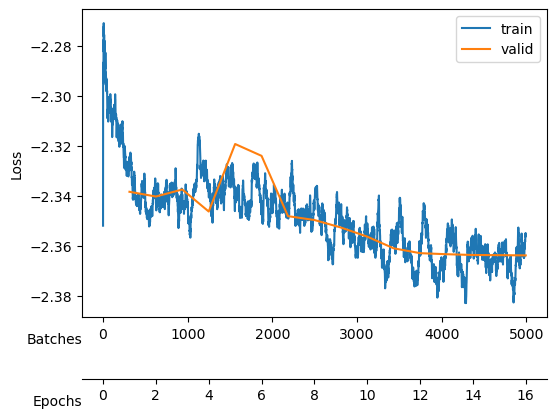

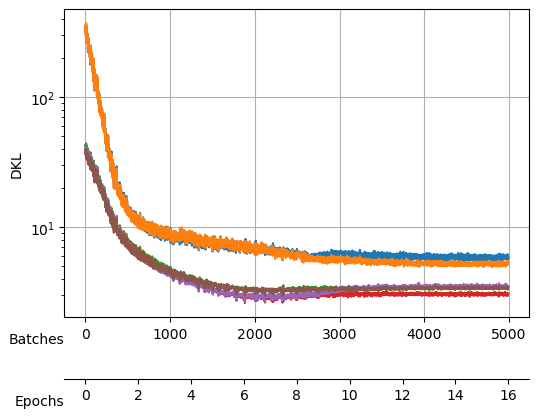

In [ ]:
learn.fit_one_cycle(16, lr_max=1e-3,)

We save the model after each cycle, just in case all the neurons collapse due to a big $\beta$.

In [ ]:
E=64+16; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E80.tar


Then, we increase the $\beta$ and train again.

In [ ]:
learn.loss_func.beta=6e-4; model_args.update(dict(beta=6e-4))

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-2.353231,-2.353524,-2.364641,18.528250,01:09
1,-2.348532,-2.352497,-2.362990,17.487579,01:10
2,-2.342875,-2.334392,-2.344330,16.562178,01:11
3,-2.346903,-2.336486,-2.345794,15.511265,01:10
4,-2.330870,-2.346205,-2.356031,16.375021,01:10
5,-2.349575,-2.353170,-2.362580,15.683105,01:10
6,-2.347398,-2.351249,-2.360387,15.228333,01:11
7,-2.345601,-2.350861,-2.359752,14.819258,01:10
8,-2.352276,-2.356376,-2.364991,14.358064,01:10
9,-2.356200,-2.355854,-2.364318,14.105173,01:10


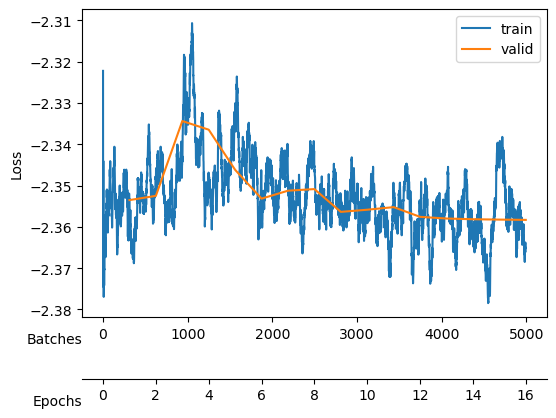

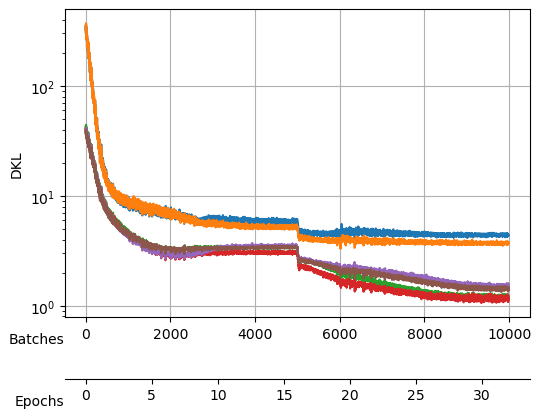

In [ ]:
learn.fit_one_cycle(16, lr_max=1e-3,)

In [ ]:
E=64+16*2; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E96.tar


We keep training to noise out the collapsed neurons while maintaining good reconstruction loss `mix_gaussian_loss`.

In [ ]:
learn.loss_func.beta=1e-3; model_args.update(dict(beta=1e-3))

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-2.348945,-2.353240,-2.364978,11.738488,01:10
1,-2.358876,-2.342992,-2.353953,10.961354,01:10
2,-2.350276,-2.350280,-2.360747,10.466887,01:11
3,-2.341486,-2.282615,-2.292582,9.966481,01:11
4,-2.342745,-2.343670,-2.353052,9.381420,01:10
5,-2.345502,-2.333569,-2.343357,9.788860,01:10
6,-2.361416,-2.354589,-2.363912,9.322714,01:10
7,-2.350763,-2.352047,-2.361214,9.165956,01:11
8,-2.354032,-2.354136,-2.363111,8.974744,01:10
9,-2.351079,-2.355446,-2.364451,9.005571,01:10


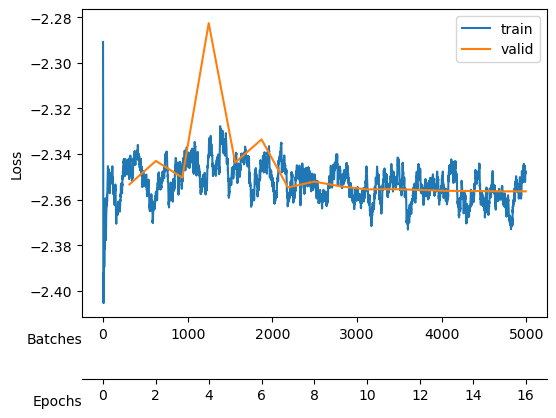

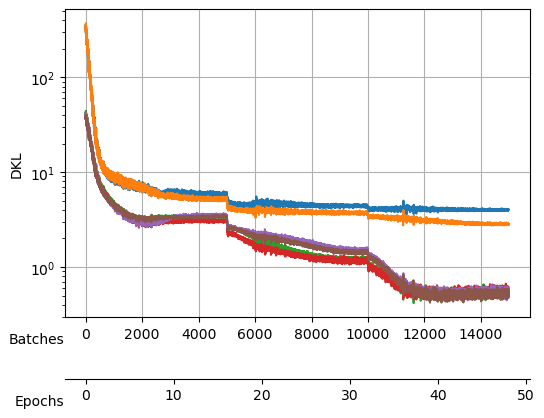

In [ ]:
learn.fit_one_cycle(16, lr_max=1e-3,)

In [ ]:
E=64+16*3; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E112.tar


In [ ]:
learn.loss_func.beta=2e-3; model_args.update(dict(beta=2e-3))

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-2.350208,-2.348301,-2.362810,7.254685,01:10
1,-2.337677,-2.346455,-2.359850,6.697080,01:11
2,-2.345940,-2.336791,-2.349714,6.461686,01:11
3,-2.339710,-2.338348,-2.351251,6.451570,01:10
4,-2.344926,-2.340880,-2.353410,6.265362,01:11
5,-2.349301,-2.347707,-2.359997,6.144722,01:11
6,-2.336591,-2.344263,-2.356583,6.159823,01:10
7,-2.345398,-2.346607,-2.358751,6.072074,01:10
8,-2.342644,-2.346272,-2.358593,6.160376,01:10
9,-2.345847,-2.348051,-2.360079,6.013485,01:11


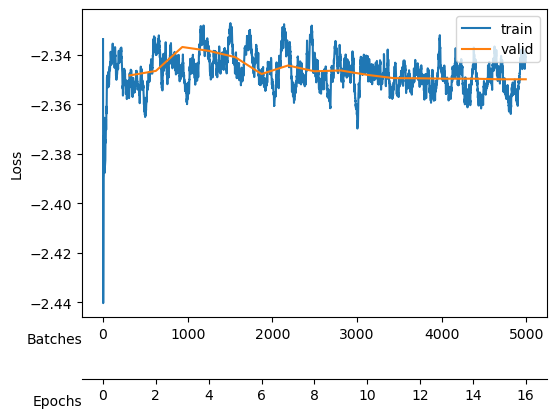

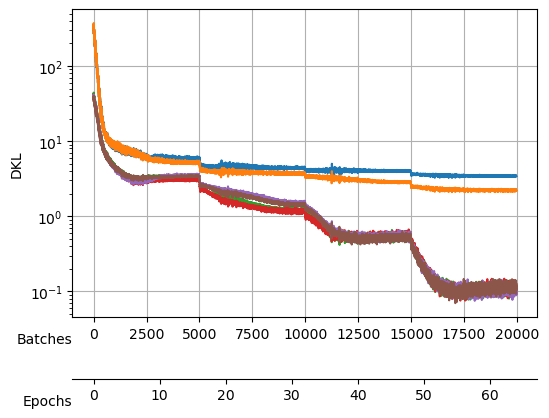

In [ ]:
learn.fit_one_cycle(16, lr_max=1e-3,)

In [ ]:
E=64+16*4; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E128.tar


In [ ]:
learn.loss_func.beta=4e-3; model_args.update(dict(beta=4e-3))

epoch,train_loss,valid_loss,mix_gaussian_loss,kld,time
0,-2.344279,-2.338168,-2.358795,5.156413,01:10
1,-2.345974,-2.335615,-2.355980,5.091214,01:14
2,-2.328641,-2.337625,-2.357382,4.939382,01:11
3,-2.320290,-2.328844,-2.348158,4.828393,01:11
4,-2.326955,-2.337008,-2.356167,4.790024,01:11
5,-2.326622,-2.334390,-2.353814,4.856228,01:10
6,-2.328627,-2.337150,-2.356401,4.812714,01:11
7,-2.324614,-2.339001,-2.358472,4.867772,01:11
8,-2.321634,-2.339200,-2.358446,4.811536,01:10
9,-2.346042,-2.339435,-2.358616,4.795233,01:10


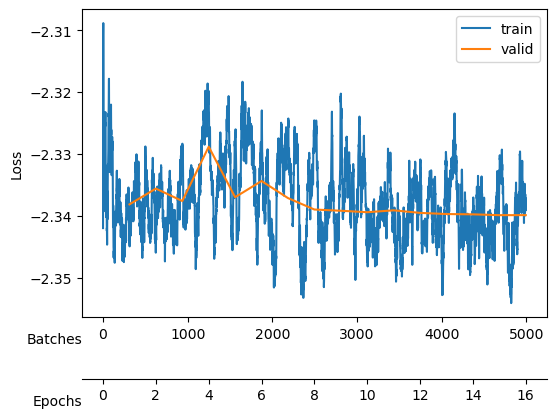

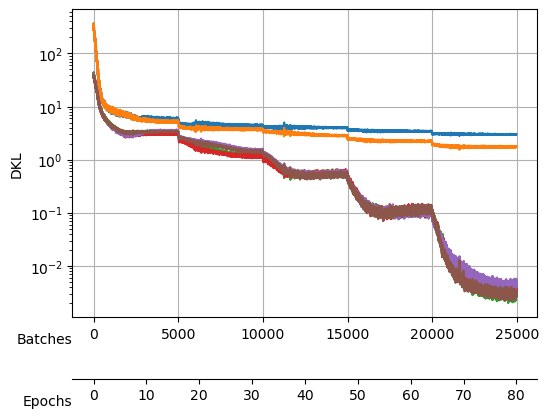

In [ ]:
learn.fit_one_cycle(16, lr_max=1e-3,)

In [ ]:
E=64+16*5; model_name = 'fbm' + f'_E{E}'
if not os.path.exists("./models/"+model_name+'.tar'):
    save_model("./models/"+model_name, model, model_args, ds_args)

Saved at ./models/fbm_E144.tar


After training, we observe a good reconstruction loss around -2.36, while the $D_{KL}$ is on the order of one for two neurons and the rest are three orders of magnitude below. We say that two neurons _survive_ while the rest are noised out. We will see in the [analysis tutorial](analysis_fbm.html) how these two neurons encode the minimal relevant information to generate the trajectories.